In [45]:
from paper_plots import plot_hp_convergence
import numpy as np
from domains import Waveguide, ScattererShape, ScattererType
from FEM_solution import FEM_solution


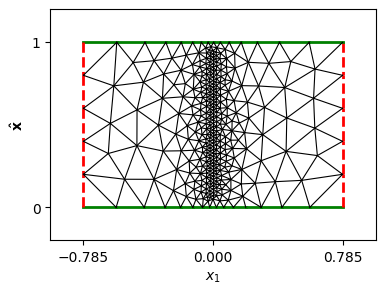

In [148]:
kappa = 8.
R = 2*np.pi/kappa
H = 1.

c = (0,0.6*H)
Domain = Waveguide(R=R,H=H)

rad = 0.3*H
length = rad
width = rad

scatterer_shape = ScattererShape.RECTANGLE
scatterer_type = ScattererType.ABSORBING

#Domain.add_scatterer( ScattererShape.CIRCLE, ScattererType.SOUND_SOFT, (c, rad))
# Domain.add_scatterer( scatterer_shape=scatterer_shape, scatterer_type=scatterer_type, params=(c, rad, rad))
Domain.add_fine_mesh_region(h_min=0.02)

Domain.generate_mesh(h_max=H/5)
Domain.plot_mesh()

In [97]:
Ny = 50
Nx = 10*Ny
x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)
t = 0
N = 9 + 4j

Z = FEM_solution( R=R, H=H, params={"c":c, "height" : length, "width" : width}, scatterer_shape=scatterer_shape, scatterer_type=scatterer_type, 
                 n=t,k_e=kappa,k_i= np.sqrt(N)*kappa, X=X, Y=Y, delta_PML=0.5*R, alpha=0.5*(4+2*1j))

NDOF: 45791


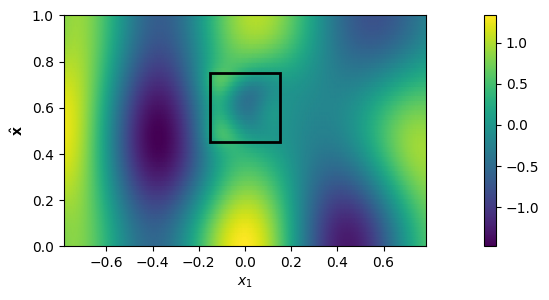

In [99]:
Domain.plot_field(X, Y, np.real(Z))

In [137]:
from Trefft_tools import  TrefftzSpace, AssembleMatrix, AssembleRHS, Assemble_blockMatrix
Nth = 15
th_0 = np.e/np.pi
th_0 = 0.
V = TrefftzSpace(Domain=Domain, DOF_per_element=Nth, kappa=kappa, n= {"Omega_i" : N, "Omega_e" : 1}, th0=th_0 )
N_modes = 15 #Number of modes for the DtN map
# "UWVF" parameters
a = 0.5
b = 0.5
d_1 = 0.5
d_2 = 0.5
A_old = AssembleMatrix(V=V, Edges=Domain.Edges, H=H, Np=N_modes, a=a, b=b, d_1=d_1, d_2=d_2)
A_block, _ = Assemble_blockMatrix(V=V, Edges=Domain.Edges, th_0=th_0, H=H, k=kappa, N_p=Nth, a=a, b=b, d_1=d_1, d_2=d_2, N_DtN=N_modes)

NDOF = A_block.shape[0]
print(f'{NDOF} degrees of freedom.\n Matrix with {np.count_nonzero(A.toarray())} non-zero entries from a total of {NDOF**2}.\n "fullness" ratio: {np.count_nonzero(A.toarray())/NDOF**2 * 100 : .2f}%')

we are in the absorbing case
12240 degrees of freedom.
 Matrix with 176643 non-zero entries from a total of 149817600.
 "fullness" ratio:  0.12%


In [138]:
B = AssembleRHS(V, Domain.Edges, kappa, H, d_2=d_2, t = t)
from Trefft_tools import TrefftzFunction
#this should be a "solve system"
from scipy.sparse.linalg import spsolve 
A = A_block.tocsc()
DOFs = spsolve(A,B)
f = TrefftzFunction(V,DOFs)

In [139]:
u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])


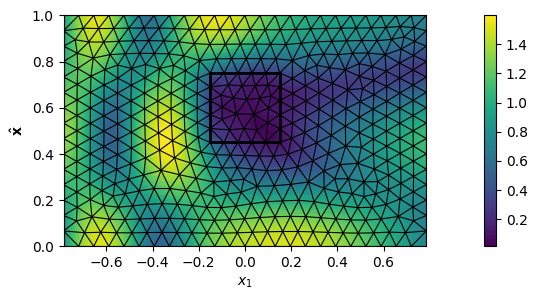

In [140]:
Domain.plot_field(X,Y,np.abs(u_Trefft), show_edges=True)


The relative error is:  1.06e-01


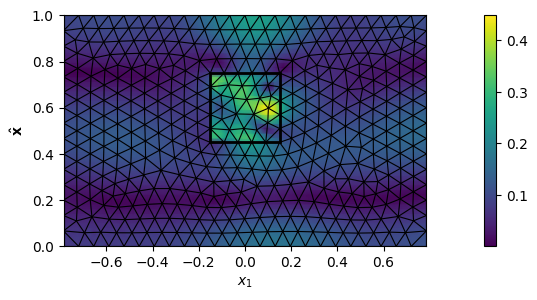

In [141]:
Domain.plot_field(X,Y,np.abs(u_Trefft - Z), show_edges=True)
print(f'The relative error is: {Domain.L2_norm(X,Y,np.abs(u_Trefft - Z))/Domain.L2_norm(X,Y,np.abs(Z)) : .2e}')

In [142]:
A_old = A_old.tocsc()
DOFs = spsolve(A_old,B)
f = TrefftzFunction(V,DOFs)

The relative error is:  1.06e-01


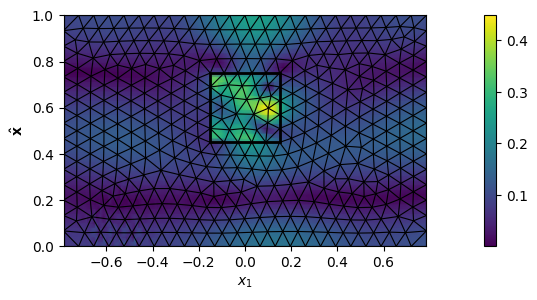

In [143]:
u_Trefft_old =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])
Domain.plot_field(X,Y,np.abs(u_Trefft_old - Z), show_edges=True)
print(f'The relative error is: {Domain.L2_norm(X,Y,np.abs(u_Trefft_old - Z))/Domain.L2_norm(X,Y,np.abs(Z)) : .2e}')


The relative error is: 0.005186606437728755


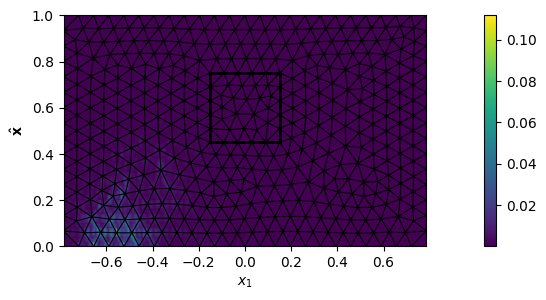

In [144]:
Domain.plot_field(X,Y,np.abs(u_Trefft_old - u_Trefft), show_edges=True)
print(f'The relative error is: {Domain.L2_norm(X,Y,np.abs(u_Trefft_old - u_Trefft))/Domain.L2_norm(X,Y,np.abs(Z))}')


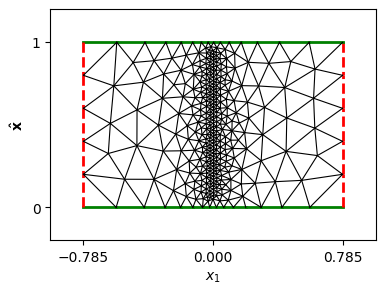

In [149]:
kappa = 8.
R = 2*np.pi/kappa
H = 1.

Domain = Waveguide(R=R,H=H)
Domain.add_fine_mesh_region(h_min=0.02)

Domain.generate_mesh(h_max=H/5)
Domain.plot_mesh()

In [ ]:
refinements = range(3,10,1)
N_ths = [3,5,7,9,11,13,15]


N_ref = len(refinements)
N_N_th = len(N_ths)

hs = np.zeros((N_ref), dtype=np.float64)
Hs = np.zeros((N_ref), dtype=np.float64)

conds = np.zeros((N_ref,N_N_th), dtype=np.float64)
errors = np.zeros((N_ref,N_N_th), dtype=np.float64)

factor = 8/8

kappa = factor*8.

R = factor*2*np.pi/kappa
H = 1.

Ny = 100
Nx = int(R/H*Ny)

x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)

t = 1
beta = np.emath.sqrt(kappa**2 - (t*np.pi/H)**2)
u_exact = np.exp(1j*beta*X)*np.cos(t*np.pi*Y/H)


for (i,N) in enumerate(refinements):
    print(f"working on refinement: {N=}")
    h = H/N
    hs[i] = h
   
    Domain = Waveguide(R=R,H=H) 
    Domain.add_fine_mesh_region(factor = 0.9, h_min = 0.01)

    Domain.generate_mesh(h_max=h)

    side_ls = np.array([E.l for E in Domain.Edges])
    h_max = np.max(side_ls)
    Hs[i] = h_max
    print(f'{h_max=}')

    if i == 0:
        print('Initial refinement:')
        Domain.plot_mesh()

    for (j,Nth) in enumerate(N_ths):
        print(f"N_theta={Nth}...")
        th_0 = np.e/np.pi # no correct direction in the basis
        #th_0 = 0
        V = TrefftzSpace(Domain, Nth, kappa=kappa, n={"Omega_i" : 1 , "Omega_e" : 1}, th0=th_0 )
        N_modes = 15 #Number of modes for the DtN map
        # "UWVF" parameters
        a = 0.5
        b = 0.5
        d_1 = 0.5
        d_2 = 0.5

        A = Assemble_blockMatrix( V=V, Edges=Domain.Edges, H=H, k=kappa, N_p = Nth, th_0=th_0, a=a, b=b, d_1=d_1, d_2=d_2, N_DtN=N_modes)
        # B = AssembleGreenRHS_left(V = V, Edges=Domain.Edges, k=kappa_e, H=H, d_2=d_2, x_0 = c[0], y_0 = c[1], M = M)
        B = AssembleRHS(V=V, Edges=Domain.Edges, k=kappa, H=H, d_2=1/2, t=t)
        A = A.tocsc()
        
        DOFs = spsolve(A,B)
        f = TrefftzFunction(V,DOFs)

        u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])
        errors[i,j] = Domain.L2_norm(X,Y,u_exact-u_Trefft)/Domain.L2_norm(X,Y,u_exact)
